In [14]:
# Imports
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
RAW_DATA_PATH = '../data/raw/' # raw csv files
INTERIM_DATA_PATH = '../data/interim/' # cached dataframes

The raw dataset can be downloaded [here](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data). I wrote a bash script to inflate all zip files - recommended. These are the csv files:

- products.csv
- orders.csv
- order_products__train.csv
- departments.csv
- aisles.csv
- order_products__prior.csv
- sample_submission.csv

We'll load them into dataframes and see how they look like. We are only concerned with users, their orders and the products in each order. 

In [30]:
train_products = pd.read_csv(os.path.join(RAW_DATA_PATH, "order_products__train.csv"))
prior_products = pd.read_csv(os.path.join(RAW_DATA_PATH, "order_products__prior.csv"))
orders = pd.read_csv(os.path.join(RAW_DATA_PATH, "orders.csv"))
products = pd.read_csv(os.path.join(RAW_DATA_PATH, "products.csv"))

In [31]:
train_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [32]:
prior_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [23]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [24]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


To process the entire dataset as a single design matrix, I'll merge the prior + train products to their respective orders. This will be a good starting point to parse each user and their ordered products.

In [33]:
order_products = pd.concat([prior_products, train_products], axis=0)

In [36]:
df = orders.merge(order_products, how='left', on='order_id')
df = df.merge(products, how='left', on='product_id')
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0


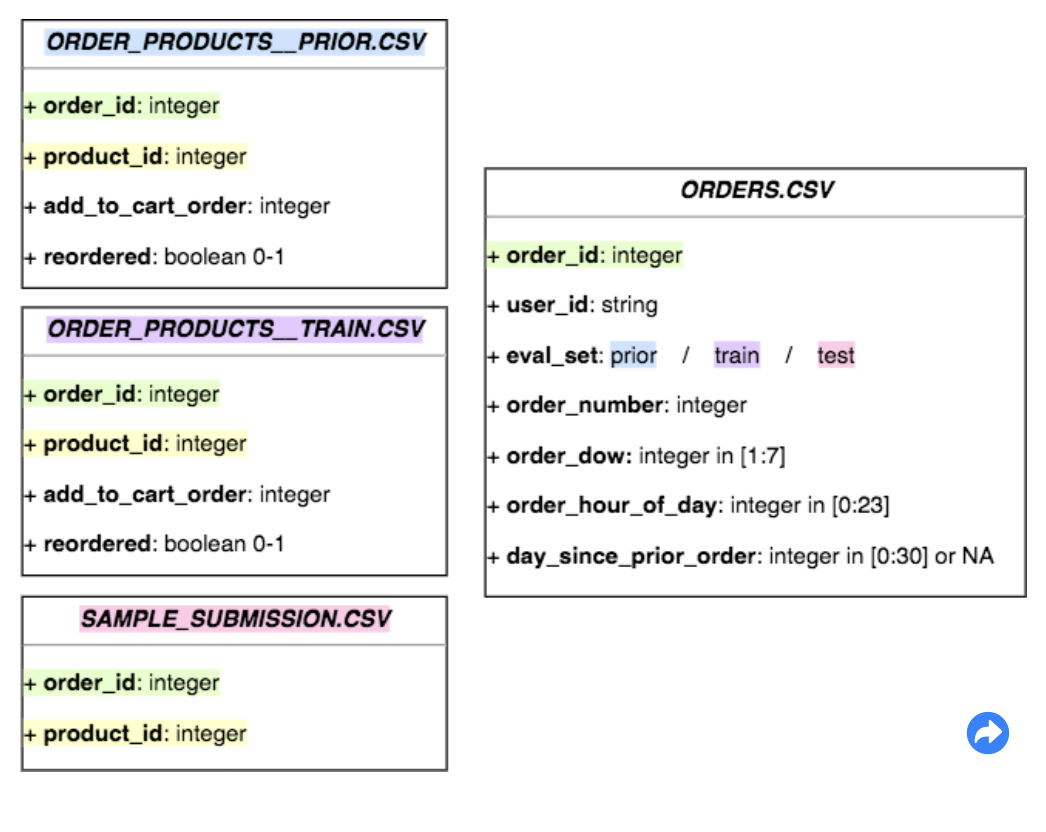

The above schema has been flattened into a single dataframe containing all users. We can now group by user_id. Each user will have several orders which can be joined. Each order will have a list of associated products which can also be joined.

We will define two functions parse_user and parse_order to do the concatenation per user.

It is a good practice to cache data that has already been preprocessed in a directory such as 'data/interim'. No need to process the same data multiple times - we can just load it as a dataframe object.

In [40]:
# Returns a series with concatenated order attributes
def parse_order(x):
    series = pd.Series(dtype='float64')

    series['products'] = '_'.join(x['product_id'].values.astype(str).tolist())
    series['reorders'] = '_'.join(x['reordered'].values.astype(str).tolist())
    series['aisles'] = '_'.join(x['aisle_id'].values.astype(str).tolist())
    series['departments'] = '_'.join(x['department_id'].values.astype(str).tolist())

    series['order_number'] = x['order_number'].iloc[0]
    series['order_dow'] = x['order_dow'].iloc[0]
    series['order_hour'] = x['order_hour_of_day'].iloc[0]
    series['days_since_prior_order'] = x['days_since_prior_order'].iloc[0]

    return series

# Returns a series with concatenated user attributes
def parse_user(x):
    # fetch parsed order as flat list of products delimited by '_'
    parsed_orders = x.groupby('order_id', sort=False).apply(parse_order)

    series = pd.Series(dtype='float64')

    series['order_ids'] = ' '.join(parsed_orders.index.map(str).tolist())
    series['order_numbers'] = ' '.join(parsed_orders['order_number'].map(str).tolist())
    series['order_dows'] = ' '.join(parsed_orders['order_dow'].map(str).tolist())
    series['order_hours'] = ' '.join(parsed_orders['order_hour'].map(str).tolist())
    series['days_since_prior_orders'] = ' '.join(parsed_orders['days_since_prior_order'].map(str).tolist())

    series['product_ids'] = ' '.join(parsed_orders['products'].values.astype(str).tolist())
    series['aisle_ids'] = ' '.join(parsed_orders['aisles'].values.astype(str).tolist())
    series['department_ids'] = ' '.join(parsed_orders['departments'].values.astype(str).tolist())
    series['reorders'] = ' '.join(parsed_orders['reorders'].values.astype(str).tolist())

    series['eval_set'] = x['eval_set'].values[-1]

    return series

In [46]:
user_data = df.head(20).groupby('user_id', sort=False).apply(parse_user).reset_index()

In [47]:
user_data

,user_id,order_ids,order_numbers,order_dows,order_hours,days_since_prior_orders,product_ids,aisle_ids,department_ids,reorders,eval_set
0,1,2539329 2398795 473747 2254736,1 2 3 4,2 3 3 4,8 7 12 7,nan 15.0 21.0 29.0,196.0_14084.0_12427.0_26088.0_26405.0 196.0_10...,77.0_91.0_23.0_23.0_54.0 77.0_117.0_23.0_24.0_...,7.0_16.0_19.0_19.0_17.0 7.0_19.0_19.0_4.0_19.0...,0.0_0.0_0.0_0.0_0.0 1.0_0.0_1.0_0.0_1.0_0.0 1....,prior


In [ ]:
if os.path.exists(INTERIM_DATA_PATH + 'users_orders.pkl'):
    with open(INTERIM_DATA_PATH + 'users_orders.pkl', 'rb') as f:
        users_orders = pickle.load(f)
else:
    order_products_prior = pd.read_csv(RAW_DATA_PATH + 'order_products__prior.csv')
    users_orders = pd.merge(order_products_prior, orders[['user_id', 'order_id', 'order_number', 'days_up_to_last']], 
                on = ['order_id'], how = 'left')
    with open(INTERIM_DATA_PATH + 'users_orders.pkl', 'wb') as f:
        pickle.dump(users_orders, f, pickle.HIGHEST_PROTOCOL)

In [67]:
users_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,days_up_to_last
0,2,33120,1,1,202279,3,153.0
1,2,28985,2,1,202279,3,153.0
2,2,9327,3,0,202279,3,153.0
3,2,45918,4,1,202279,3,153.0
4,2,30035,5,0,202279,3,153.0
